**Lab 1 CT-221**: Predição de séries temporais


**Equipe**: Victor Hugo de Oliveira Bastos, Leonardo Antônio Lugarini, José Eduardo Teixeira Araújo, Marcel Versiani, Rafael Otero

>[Preparação dos dados](#scrollTo=PVReDV-SVMVX)

>>[Importando pacotes e dados](#scrollTo=efpR3GuWVMVc)

>>[Aplicando os modelos](#scrollTo=LHNzVtsrY7AG)

>>>[[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt](#scrollTo=FUZnaVtqVSCO)

>>>[[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt](#scrollTo=Uqu36GzdVYh8)

>>>[[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation](#scrollTo=4pekYAa4ae7l)

>>>[[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient](#scrollTo=H1UzQr-bVxzV)

>>>[[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization](#scrollTo=fbGBxtj_XKLv)

>>>[[6] 10-25-25-1, r = p = 25, Tanh / RMSprop](#scrollTo=ziJ-KWiOb50H)

>>[Analisando os resultados](#scrollTo=iA97S80t7h18)



 <a name='prep'></a>
#Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [253]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import visualkeras
# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use('ggplot')

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [254]:
# Carregando os dados...

def carregar_dados(url):
  # URL dos arquivos CSV
  url_data = url
  # Extração do identificador do arquivo da URL
  identificador = url.split('/')[-2]
  # Construção do link de download direto do arquivo
  url_download = 'https://drive.google.com/uc?id=' + identificador

  #Retorna dataframe
  return pd.read_csv(url_download, on_bad_lines='skip', sep=',',parse_dates=['Date'], index_col=['Date'])


# URL dos arquivos CSV
url_data_embr = 'https://drive.google.com/file/d/1JkBgws5aVCpP9Xunv_51Pkhv8QdM6ZKT/view?usp=drive_link'
url_data_petr = 'httpsn://drive.google.com/file/d/1tvv9iIqA9bOpR31c545e59oOzbkXxmpv/view?usp=drive_link'
url_data_vale = 'https://drive.google.com/file/d/1JxYLJ9EQHnN0XGUmOBdd7as_EDsV9CKX/view?usp=drive_link'

embr = carregar_dados(url_data_embr)
petr = carregar_dados(url_data_petr)
vale = carregar_dados(url_data_vale)

companies = dict({'Petr':petr, 'Embr':embr, 'Vale':vale})

In [255]:
petr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.990000,17.330000,16.980000,17.330000,6.917481,4488000
2018-01-03,17.240000,17.670000,17.209999,17.549999,7.005296,9771700
2018-01-04,17.670000,17.900000,17.629999,17.700001,7.065169,6816500
2018-01-05,17.690001,17.850000,17.600000,17.840000,7.121052,4646500
2018-01-08,17.639999,18.120001,17.610001,18.120001,7.232818,4763400


<a name='ana'></a>
## Aplicando os modelos

In [256]:
petr_close = petr[:-90]['Close']
embr_close = embr[:-90]['Close']
vale_close = vale[:-90]['Close']

In [257]:
date_index  = petr[-90:].index

<a name='ana'></a>
###[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt

In [258]:
r_1 = 15
p_1 = 0

# Função para criar amostras NARMAX
def create_narmax_samples(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX
def train_narmax_model(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_1 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_1 = MinMaxScaler()
normalized_data_1 = scaler_1.fit_transform(combined_data_1)

# Dividir os dados em treinamento e teste
train_size_1 = int(0.8 * normalized_data_1.shape[0])
train_data_1 = normalized_data_1[:train_size_1]
test_data_1 = normalized_data_1[train_size_1:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_1 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_1, y_train_1 = create_narmax_samples(train_data_1, sequence_length_1)
X_test_1, y_test_1 = create_narmax_samples(test_data_1, sequence_length_1)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_petr_1, X_train_1, y_train_1[:, 0], X_test_1, y_test_1[:, 0])

model_vale_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_vale_1, X_train_1, y_train_1[:, 1], X_test_1, y_test_1[:, 1])

model_embr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_embr_1, X_train_1, y_train_1[:, 2], X_test_1, y_test_1[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_1 = normalized_data_1[-sequence_length_1:, :]

predicted_1 = make_predictions([model_petr_1,
                              model_vale_1,
                              model_embr_1],
                              last_10_days_1, 90)

# Imprima as previsões
petr_predictions_1 = []
embr_predictions_1 = []
vale_predictions_1 = []

for i in predicted_1:
    petr_predictions_1.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_1.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_1.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.0958 - val_loss: 0.0742
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0464
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0350
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0273
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0167
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0079
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0065
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 11/50
32/32 

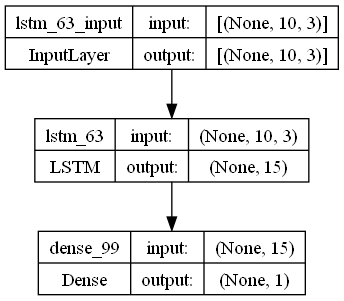

In [259]:
plot_model(model_petr_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [260]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_1)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_1)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_1)

Previsão para os próximos 90 dias de PETR:
[26.449339661477744, 26.3050968825019, 26.274605459683777, 26.317142876701652, 26.41706425310558, 26.533938038617315, 26.67124855160743, 26.81278534637898, 26.963371185102524, 27.119443552283286, 27.241612919786213, 27.388083407532395, 27.52318076005435, 27.64910358951807, 27.767815916716994, 27.88133995565325, 27.99044494780427, 28.095980150309444, 28.19786736604458, 28.296039309112132, 28.390205013468623, 28.478464107142628, 28.562078655347705, 28.640954094119728, 28.715072238080978, 28.784520377044498, 28.849489457476317, 28.910223163437845, 28.967007005359232, 29.020097397066294, 29.069732567007126, 29.116107098723294, 29.1593173747167, 29.199514333622396, 29.236865280915378, 29.271522973768473, 29.30364198789227, 29.333378717535137, 29.36088410133213, 29.38630907791829, 29.40979731177759, 29.431490648856222, 29.451514568260432, 29.469996367634238, 29.48703606655508, 29.502739140213727, 29.517203789649844, 29.530519123214244, 29.5427687936

<a name='ana'></a>
###[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt

In [261]:
# Renamed variables
r_2 = 10
p_2 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_2(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_2(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX
def train_narmax_model_2(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_2(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_2 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_2 = MinMaxScaler()
normalized_data_2 = scaler_2.fit_transform(combined_data_2)

# Dividir os dados em treinamento e teste
train_size_2 = int(0.8 * normalized_data_2.shape[0])
train_data_2 = normalized_data_2[:train_size_2]
test_data_2 = normalized_data_2[train_size_2:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_2 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_2, y_train_2 = create_narmax_samples_2(train_data_2, sequence_length_2)
X_test_2, y_test_2 = create_narmax_samples_2(test_data_2, sequence_length_2)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_petr_2, X_train_2, y_train_2[:, 0], X_test_2, y_test_2[:, 0])

model_vale_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_vale_2, X_train_2, y_train_2[:, 1], X_test_2, y_test_2[:, 1])

model_embr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_embr_2, X_train_2, y_train_2[:, 2], X_test_2, y_test_2[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_2 = normalized_data_2[-sequence_length_2:, :]

predicted_2 = make_predictions_2([model_petr_2,
                              model_vale_2,
                              model_embr_2],
                              last_10_days_2, 90)

# Imprima as previsões
petr_predictions_2 = []
embr_predictions_2 = []
vale_predictions_2 = []

for i in predicted_2:
    petr_predictions_2.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_2.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_2.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 7ms/step - loss: 0.0967 - val_loss: 0.0109
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/50
32/32 [

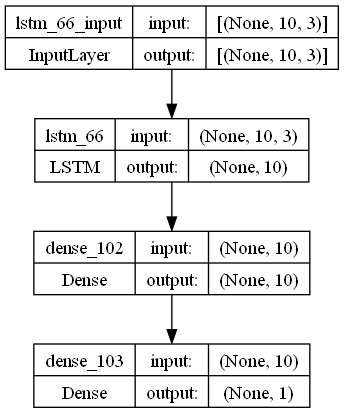

In [262]:
plot_model(model_petr_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [263]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_2)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_2)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_2)

Previsão para os próximos 90 dias de PETR:
[25.232469657887904, 25.379025616909356, 25.508300920755207, 25.59831581264779, 25.67372693696472, 25.709239342570513, 25.702187053091855, 25.572860830188393, 25.359239016684356, 25.091052886609287, 24.7496206014345, 24.514078133630363, 24.272636329294834, 24.027018252966585, 23.781947556507617, 23.54188693160969, 23.308238470894786, 23.081206759862212, 22.860795435587526, 22.646779908655912, 22.438650988491297, 22.234923839003088, 22.038059851065277, 21.84821905600178, 21.665322347419533, 21.48931062284094, 21.32018751934156, 21.157953036921384, 21.002588080933812, 20.8540244562124, 20.712177600750774, 20.57691567056048, 20.44805772113323, 20.325438265531808, 20.208879996323468, 20.09714812636122, 19.990239927838417, 19.888223595921488, 19.790909093413294, 19.698099108965607, 19.609599968305737, 19.52523163619429, 19.444841355458436, 19.368284552345337, 19.295421199446558, 19.226126726924747, 19.160253833220395, 19.09766340019396, 19.03822449

<a name='ana'></a>
###[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation

In [264]:
r_3 = 10
p_3 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_3(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_3(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Resilient Backpropagation
def train_narmax_model_rp_3(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_3(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_3 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_3 = MinMaxScaler()
normalized_data_3 = scaler_3.fit_transform(combined_data_3)

# Dividir os dados em treinamento e teste
train_size_3 = int(0.8 * normalized_data_3.shape[0])
train_data_3 = normalized_data_3[:train_size_3]
test_data_3 = normalized_data_3[train_size_3:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_3 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_3, y_train_3 = create_narmax_samples_3(train_data_3, sequence_length_3)
X_test_3, y_test_3 = create_narmax_samples_3(test_data_3, sequence_length_3)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_3
model_petr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_petr_3, X_train_3, y_train_3[:, 0], X_test_3, y_test_3[:, 0])

model_vale_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_vale_3, X_train_3, y_train_3[:, 1], X_test_3, y_test_3[:, 1])

model_embr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_embr_3, X_train_3, y_train_3[:, 2], X_test_3, y_test_3[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_3 = normalized_data_3[-sequence_length_3:, :]

predicted_3 = make_predictions_3([model_petr_3,
                              model_vale_3,
                              model_embr_3],
                              last_10_days_3, 90)

# Imprima as previsões
petr_predictions_3 = []
embr_predictions_3 = []
vale_predictions_3 = []

for i in predicted_3:
    petr_predictions_3.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_3.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_3.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 7ms/step - loss: 0.1475 - val_loss: 0.2313
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.1043 - val_loss: 0.2012
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.1010 - val_loss: 0.1949
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0991 - val_loss: 0.1828
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0976 - val_loss: 0.1810
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0964 - val_loss: 0.1771
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0954 - val_loss: 0.1726
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1705
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0944 - val_loss: 0.1712
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.1704
Epoch 11/50
32/32 [

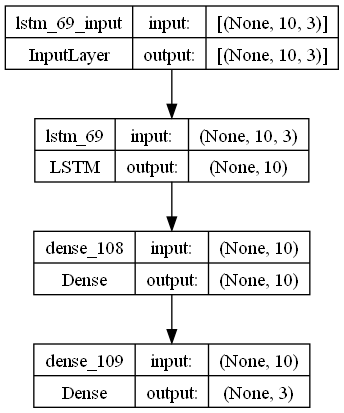

In [265]:
plot_model(model_petr_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [266]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_3)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_3)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_3)

Previsão para os próximos 90 dias de PETR:
[26.222037897586077, 24.397458943406672, 23.211935075387657, 22.269917961343943, 21.549915212620675, 21.02605903868428, 20.67433837606609, 20.462036820984302, 20.37721021735439, 20.39440812906137, 20.491001581343085, 20.402121457020044, 20.338305329535487, 20.29506595693773, 20.264687283461452, 20.24470064408156, 20.22887300058556, 20.2066222816799, 20.181184575329333, 20.157575408708215, 20.135127378454328, 20.113050329905867, 20.09240810765928, 20.07281427243808, 20.05400695480314, 20.036197105135976, 20.019151041332933, 20.002796931152016, 19.98719296780193, 19.97237643130699, 19.958302767491787, 19.944929240718693, 19.932218570963386, 19.920130750394883, 19.908622134106665, 19.897665444032164, 19.887229765029254, 19.87729600245133, 19.867835059694052, 19.858829660648585, 19.850256164323895, 19.84209638534227, 19.834324864174903, 19.826936145208478, 19.819900222569764, 19.813202547956585, 19.806830391604542, 19.800765568135915, 19.794995347

<a name='ana'></a>
###[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient

In [267]:
r_4 = 25
p_4 = 0

# Função para criar amostras NARMAX
def create_narmax_samples_4(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_4(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(10, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Polak-Ribière Conjugate Gradient
def train_narmax_model_cgp_4(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_4(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_4 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_4 = MinMaxScaler()
normalized_data_4 = scaler_4.fit_transform(combined_data_4)

# Dividir os dados em treinamento e teste
train_size_4 = int(0.8 * normalized_data_4.shape[0])
train_data_4 = normalized_data_4[:train_size_4]
test_data_4 = normalized_data_4[train_size_4:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_4 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_4, y_train_4 = create_narmax_samples_4(train_data_4, sequence_length_4)
X_test_4, y_test_4 = create_narmax_samples_4(test_data_4, sequence_length_4)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_cgp_4
model_petr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_petr_4, X_train_4, y_train_4[:, 0], X_test_4, y_test_4[:, 0])

model_vale_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_vale_4, X_train_4, y_train_4[:, 1], X_test_4, y_test_4[:, 1])

model_embr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_embr_4, X_train_4, y_train_4[:, 2], X_test_4, y_test_4[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_4 = normalized_data_4[-sequence_length_4:, :]

predicted_4 = make_predictions_4([model_petr_4,
                              model_vale_4,
                              model_embr_4],
                              last_10_days_4, 90)

# Imprima as previsões
petr_predictions_4 = []
embr_predictions_4 = []
vale_predictions_4 = []

for i in predicted_4:
    petr_predictions_4.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_4.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_4.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 7ms/step - loss: 0.2030 - val_loss: 0.2768
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.1140 - val_loss: 0.1524
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.0640
Epoch 4/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0187 - val_loss: 0.0394
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.0343
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0316
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0273
Epoch 8/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0257
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0223
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0212
Epoch 11/50
32/32 [

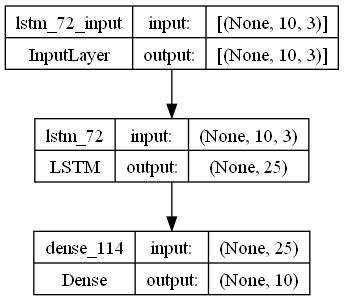

In [268]:
plot_model(model_petr_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [269]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_4)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_4)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_4)

Previsão para os próximos 90 dias de PETR:
[26.74735617589092, 26.718388687725486, 26.446069930564224, 26.18004604189971, 25.930580848915426, 25.712938248398153, 25.513653786686213, 25.328047456824123, 25.141272716443716, 24.945954485611857, 24.781885098580034, 24.61739290151629, 24.457866221838177, 24.305281810103537, 24.16081626025066, 24.023186593881608, 23.891340786895455, 23.765595264864473, 23.646185528430102, 23.53196862660283, 23.423843826310755, 23.32090458647469, 23.22349642927125, 23.131396583823413, 23.044385007060797, 22.962194373930963, 22.884395509519784, 22.810844749343307, 22.74146116847068, 22.676065640931398, 22.614482677830487, 22.556520423433035, 22.502000661037414, 22.450746992479772, 22.402617571813913, 22.357408722809403, 22.314974962444516, 22.275159896470875, 22.23774348181811, 22.2025984208422, 22.169644697881193, 22.138756833828836, 22.109812077385545, 22.08269767920947, 22.057303617765427, 22.03354533104703, 22.011457371271938, 21.990756955816657, 21.971384

<a name='ana'></a>
###[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization

In [270]:
r_5 = 25
p_5 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_5(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX com Bayesian Regularization
def create_narmax_model_5(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(p, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Bayesian Regularization
def train_narmax_model_br_5(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_5(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

combined_data_5 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_5 = MinMaxScaler()
normalized_data_5 = scaler_5.fit_transform(combined_data_5)

# Dividir os dados em treinamento e teste
train_size_5 = int(0.8 * normalized_data_5.shape[0])
train_data_5 = normalized_data_5[:train_size_5]
test_data_5 = normalized_data_5[train_size_5:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_5 = 6

# Crie amostras NARMAX para treinamento e teste
X_train_5, y_train_5 = create_narmax_samples_5(train_data_5, sequence_length_5)
X_test_5, y_test_5 = create_narmax_samples_5(test_data_5, sequence_length_5)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_petr_5, X_train_5, y_train_5[:, 0], X_test_5, y_test_5[:, 0])

model_vale_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_vale_5, X_train_5, y_train_5[:, 1], X_test_5, y_test_5[:, 1])

model_embr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_embr_5, X_train_5, y_train_5[:, 2], X_test_5, y_test_5[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_5 = normalized_data_5[-sequence_length_5:, :]

predicted_5 = make_predictions_5([model_petr_5,
                              model_vale_5,
                              model_embr_5],
                              last_10_days_5, 90)

# Imprima as previsões
petr_predictions_5 = []
embr_predictions_5 = []
vale_predictions_5 = []

for i in predicted_5:
    petr_predictions_5.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_5.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_5.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
33/33 [==============================] - 2s 13ms/step - loss: 0.5566 - val_loss: 0.4504
Epoch 2/50
33/33 [==============================] - 0s 3ms/step - loss: 0.3749 - val_loss: 0.3425
Epoch 3/50
33/33 [==============================] - 0s 3ms/step - loss: 0.2719 - val_loss: 0.2571
Epoch 4/50
33/33 [==============================] - 0s 3ms/step - loss: 0.2000 - val_loss: 0.1937
Epoch 5/50
33/33 [==============================] - 0s 3ms/step - loss: 0.1492 - val_loss: 0.1519
Epoch 6/50
33/33 [==============================] - 0s 3ms/step - loss: 0.1129 - val_loss: 0.1234
Epoch 7/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0866 - val_loss: 0.0945
Epoch 8/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 0.0770
Epoch 9/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0650
Epoch 10/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0536
Epoch 11/50
33/33 

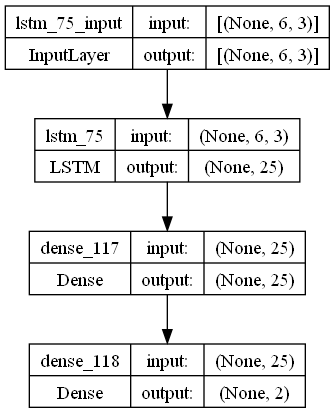

In [271]:
plot_model(model_petr_5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [272]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_5)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_5)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_5)

Previsão para os próximos 90 dias de PETR:
[27.350919769629897, 27.30696207461232, 27.335404005361735, 27.480863386106847, 27.664632083550632, 27.858426379729806, 28.181644190583228, 28.298576169303654, 28.440003851808907, 28.597994776338815, 28.75624575177008, 28.909110218321562, 29.054576873217762, 29.172614522903384, 29.29030301333684, 29.404023454352437, 29.51085345575106, 29.609918300864518, 29.70102522468901, 29.784226964819908, 29.862360440181078, 29.934896456280946, 30.0017204452399, 30.063083365270437, 30.119383476144552, 30.17105722692746, 30.218591985741973, 30.262142328298687, 30.3019592128101, 30.338328149706363, 30.371529193804324, 30.401835125769736, 30.429478718437373, 30.454669103650986, 30.477595409338832, 30.498455856118024, 30.517434116303505, 30.534682947068095, 30.55036419827348, 30.564603349025905, 30.577533152582706, 30.5892681768235, 30.59991389693904, 30.609573969582318, 30.61833750310415, 30.626282694628717, 30.633482285666883, 30.640009017729522, 30.64592290

<a name='ana'></a>
###[6] 10-25-25-1, r = p = 25, Tanh / RMSprop

In [273]:
r_6 = 25
p_6 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_6(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_6(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(p, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo RMSprop
def train_narmax_model_rp_6(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_6(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

combined_data_6 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_6 = MinMaxScaler()
normalized_data_6 = scaler_6.fit_transform(combined_data_6)

# Dividir os dados em treinamento e teste
train_size_6 = int(0.8 * normalized_data_6.shape[0])
train_data_6 = normalized_data_6[:train_size_6]
test_data_6 = normalized_data_6[train_size_6:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_6 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_6, y_train_6 = create_narmax_samples_6(train_data_6, sequence_length_6)
X_test_6, y_test_6 = create_narmax_samples_6(test_data_6, sequence_length_6)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_petr_6, X_train_6, y_train_6[:, 0], X_test_6, y_test_6[:, 0])

model_vale_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_vale_6, X_train_6, y_train_6[:, 1], X_test_6, y_test_6[:, 1])

model_embr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_embr_6, X_train_6, y_train_6[:, 2], X_test_6, y_test_6[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_6 = normalized_data_6[-sequence_length_6:, :]

predicted_6 = make_predictions_6([model_petr_6,
                              model_vale_6,
                              model_embr_6],
                              last_10_days_6, 90)

# Imprima as previsões
petr_predictions_6 = []
embr_predictions_6 = []
vale_predictions_6 = []

for i in predicted_6:
    petr_predictions_6.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_6.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_6.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.0312 - val_loss: 0.0222
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0156
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 11/50
32/32 

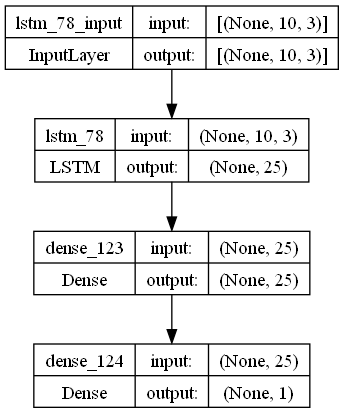

In [274]:
plot_model(model_petr_6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [275]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_6)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_6)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_6)

Previsão para os próximos 90 dias de PETR:
[26.045115085583866, 26.244358630195947, 26.536664026737093, 26.875750398186383, 27.240479970754446, 27.62532620815307, 28.005609734282494, 28.371923253249705, 28.718314690927922, 29.044547637406826, 29.340781984803737, 29.647518387832225, 29.92070095043504, 30.165710725878657, 30.38358609923071, 30.575461838060736, 30.742712756924153, 30.886900979766846, 31.009723202329816, 31.113108893188834, 31.199054806817234, 31.269512234244047, 31.32672706961733, 31.372497846793294, 31.40851398736185, 31.436306700126767, 31.457250799643457, 31.472548339379014, 31.48323224878776, 31.490193611377837, 31.49418348324895, 31.495823804319024, 31.495631039315224, 31.494023451925038, 31.49135020140064, 31.48788224987, 31.48384145894128, 31.479400589702784, 31.474697851025166, 31.46983144394809, 31.464890476822376, 31.459918594554544, 31.4549667162022, 31.450065756907463, 31.445237539123596, 31.440492974077223, 31.43583933591944, 31.431282080263554, 31.4268193885

## Analisando os resultados

In [276]:
df = pd.DataFrame(petr_predictions_1, index=date_index)
df.columns = ['Petr-pred1']

df['Embr-pred1'] = embr_predictions_1
df['Vale-pred1'] = vale_predictions_1
df['Petr-pred2'] = petr_predictions_2
df['Embr-pred2'] = embr_predictions_2
df['Vale-pred2'] = vale_predictions_2
df['Petr-pred3'] = petr_predictions_3
df['Embr-pred3'] = embr_predictions_3
df['Vale-pred3'] = vale_predictions_3
df['Petr-pred4'] = petr_predictions_4
df['Embr-pred4'] = embr_predictions_4
df['Vale-pred4'] = vale_predictions_4
df['Petr-pred5'] = petr_predictions_5
df['Embr-pred5'] = embr_predictions_5
df['Vale-pred5'] = vale_predictions_5
df['Petr-pred6'] = petr_predictions_6
df['Embr-pred6'] = embr_predictions_6
df['Vale-pred6'] = vale_predictions_6

df = df.reset_index()
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

df

,Date,Petr-pred1,Embr-pred1,Vale-pred1,Petr-pred2,Embr-pred2,Vale-pred2,Petr-pred3,Embr-pred3,Vale-pred3,Petr-pred4,Embr-pred4,Vale-pred4,Petr-pred5,Embr-pred5,Vale-pred5,Petr-pred6,Embr-pred6,Vale-pred6
0,2023-03-21,26.449340,18.448418,89.171815,25.232470,17.956718,34.099998,26.222038,17.461640,34.099998,26.747356,17.754473,34.099998,27.350920,18.906763,89.001023,26.045115,18.288165,89.805380
1,2023-03-22,26.305097,18.616524,88.880312,25.379026,14.871910,34.099998,24.397459,14.755702,34.099998,26.718389,16.072571,34.099998,27.306962,19.039407,89.097283,26.244359,18.829670,87.121315
2,2023-03-23,26.274605,18.750886,88.546895,25.508301,13.035561,34.099998,23.211935,12.479716,34.099998,26.446070,14.399798,34.099998,27.335404,19.229549,88.859889,26.536664,18.992862,86.341653
3,2023-03-24,26.317143,18.883426,88.269907,25.598316,11.560358,34.099998,22.269918,10.782709,34.099998,26.180046,12.948578,34.099998,27.480863,19.524615,88.730104,26.875750,19.076470,86.109707
4,2023-03-27,26.417064,19.029867,88.042041,25.673727,10.330180,34.099998,21.549915,9.521736,34.099998,25.930581,11.674182,34.099998,27.664632,19.803327,88.481089,27.240480,19.131458,86.187436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2023-07-24,29.673207,20.605805,93.208420,18.130703,6.996864,34.099998,19.700082,6.247837,34.334503,21.724136,7.872661,34.099998,30.701199,21.127632,93.318636,31.298738,18.033882,81.942726
86,2023-07-25,29.673625,20.606035,93.209368,18.124033,6.996218,34.099998,19.699220,6.247786,34.334377,21.722843,7.872635,34.099998,30.701334,21.127687,93.318843,31.295730,18.016572,81.873652
87,2023-07-26,29.674004,20.606247,93.210246,18.117752,6.995611,34.099998,19.698404,6.247737,34.334255,21.721639,7.872612,34.099998,30.701457,21.127739,93.319034,31.292731,17.999294,81.804663
88,2023-07-27,29.674349,20.606448,93.211078,18.111842,6.995041,34.099998,19.697625,6.247691,34.334139,21.720520,7.872590,34.099998,30.701570,21.127784,93.319206,31.289740,17.982034,81.735756


In [279]:
colors = [
    '#003f5c',
    '#444e86',
    '#955196',
    '#dd5182',
    '#ff6e54',
    '#ffa600',
]
indice = 'Vale'
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=companies[indice].index, y=companies[indice].Close, name = 'Real Close',
                         line=dict(color='royalblue', width=1)))

for i in range(0, 6):
    pred = df.loc[:, df.columns.str.startswith(indice)].columns[i]
    fig.add_trace(go.Scatter(x=df.Date, y=df[pred], name=pred,
                            line=dict(color = colors[i])
                            )
                )

layout = dict(
        title=f'Real close and Predicition for {indice}',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    #change the count to desired amount of months.
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=12,
                         label='1y',
                         step='month',
                         stepmode='backward'),
                    dict(count=36,
                         label='3y',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
    )

fig.layout = layout
fig.show()